Course: MSc. Artificial Intelligence 2024 - 2025 (September Start)
Module Name and Code: Project Summer Module (COM7303-24-UOB-Q)
Student Name: Bogomil Iliev
Student ID: 2011184
Supervisor: PhD. Naveed Islam

Project Name: Detection and Classification of Gallbladder Diseases through Lightweight Deep Learning Techniques.

#DEMO Experiment

In [ ]:
#Checking the GPU the notebook is connected to.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 27 13:36:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   53C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#Load the Drive helper and mount the Gdrive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#0. Clean out conflicting wheels, then pin compatible versions.

Restart the runtime (required after changing NumPy)

In [ ]:
#Stabilise environment (run FIRST)
#Remove any conflicting OpenCV builds and NumPy 2.x
!pip -q uninstall -y numpy opencv-python opencv-contrib-python opencv-python-headless

#Install mutually compatible versions
!pip -q install --no-cache-dir \
  "numpy==1.26.4" \
  "opencv-python==4.9.0.80" \
  "albumentations==1.4.4" \
  "timm==0.9.12" \
  "scikit-learn==1.7.1"

#Sanity-check imports (may still require restart to fully reload NumPy)
import numpy, cv2, sklearn, timm, albumentations as A
print("NumPy:", numpy.__version__)
print("OpenCV:", cv2.__version__)
print("scikit-learn:", sklearn.__version__)
print("timm:", timm.__version__)
print("Albumentations:", A.__version__)

print("\n Now go to: Runtime and then Restart runtime. After it restarts, run your imports again.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 265.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 327.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 320.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 298.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 298.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 331.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 326.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


ModuleNotFoundError: No module named 'numpy.rec'

Sanity-check imports after the restart

In [ ]:
import numpy, cv2, sklearn, timm, albumentations as A
print("NumPy:", numpy.__version__)
print("OpenCV:", cv2.__version__)
print("scikit-learn:", sklearn.__version__)
print("timm:", timm.__version__)
print("Albumentations:", A.__version__)


NumPy: 1.26.4
OpenCV: 4.9.0
scikit-learn: 1.7.1
timm: 0.9.12
Albumentations: 1.4.4


#1. Installs, imports, paths & config

In [ ]:
#Installs & Imports
!pip -q install timm==0.9.12 albumentations==1.4.4 opencv-python==4.9.0.80

from pathlib import Path
import os, random, math, json, time
from collections import defaultdict

import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_recall_fscore_support

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

#PATHS
DRIVE_ROOT  = Path("/content/drive/MyDrive/AI/Project_Summer_Module") #Project root folder. CHANGE with your own path if you are running the code on your own machine.
DATA_ROOT   = DRIVE_ROOT / "Gallblader Diseases Dataset"   #class folders inside
DEMO_DIR    = DRIVE_ROOT / "DEMO"                          #save everything here
SPLIT_DIR   = DEMO_DIR / "splits"                          #save the splits here
LOG_DIR     = DEMO_DIR / "logs"                            #save logs here
CKPT_DIR    = DEMO_DIR / "checkpoints"                     #save model checkpoints here

for p in [DEMO_DIR, SPLIT_DIR, LOG_DIR, CKPT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

#Repro and device
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

#Training hyper-params
IMG_SIZE          = 320
BATCH_SIZE        = 64          #bigger for A100; adjust if OOM
NUM_WORKERS       = 4
EPOCHS            = 50
WARMUP_EPOCHS     = 3
BASE_LR           = 3e-4        #head LR
BACKBONE_LR       = 1e-4        #backbone LR (lower)
WEIGHT_DECAY      = 1e-4        #weight decay
LABEL_SMOOTH      = 0.05        #label smoothing
EARLY_PATIENCE    = 7           #patience epochs
DROPOUT_RATE      = 0.20        #Drop out rate to control overfitting.

#Resume controls
RESUME_FROM_LAST  = True        #resume if last.pt exists

#ImageNet norm (for timm pretrained)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

print(f"[CFG] epochs={EPOCHS}, bs={BATCH_SIZE}, img={IMG_SIZE}, dropout={DROPOUT_RATE}")


Device: cuda
[CFG] epochs=50, bs=64, img=320, dropout=0.2


#2. Build manifest (scan folders and then dataframe)

In [ ]:
#1. Scan dataset into a manifest
#Assumes DATA_ROOT/<class_name>/*.png|jpg
image_exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

records = []
for cls_name in sorted(os.listdir(DATA_ROOT)):
    cls_dir = DATA_ROOT / cls_name
    if not cls_dir.is_dir():
        continue
    for root, _, files in os.walk(cls_dir):
        for f in files:
            if Path(f).suffix.lower() in image_exts:
                fp = Path(root) / f
                records.append({"filepath": str(fp), "class": cls_name, "filename": f})

df_all = pd.DataFrame(records)
if df_all.empty:
    raise SystemExit("No images found. Please check DATA_ROOT.")
class_names = sorted(df_all["class"].unique().tolist())
class_to_idx = {c:i for i,c in enumerate(class_names)}
df_all["class_idx"] = df_all["class"].map(class_to_idx).astype(int)

print(f"[SCAN] images={len(df_all):,} | classes={len(class_names)}")
print("Classes:", class_names)


[SCAN] images=10,704 | classes=10
Classes: ['1Gallstones', '2Abdomen and retroperitoneum', '3cholecystitis', '4Membranous and gangrenous cholecystitis', '5Perforation', '6Polyps and cholesterol crystals', '7Adenomyomatosis', '8Carcinoma', '9Various causes of gallbladder wall thickening', 'eda_outputs']


#3.Image-level stratified train/val/test split (no patient grouping!)

In [ ]:
#Image-level stratified split: train/val/test
#Ratios (change if you want): train 70%, val 15%, test 15%
y = df_all["class_idx"].values
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
train_idx, temp_idx = next(sss1.split(df_all, y))
df_train = df_all.iloc[train_idx].reset_index(drop=True)
df_temp  = df_all.iloc[temp_idx].reset_index(drop=True)

y_temp = df_temp["class_idx"].values
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)  #split temp 50/50 then 15/15
val_idx, test_idx = next(sss2.split(df_temp, y_temp))
df_val  = df_temp.iloc[val_idx].reset_index(drop=True)
df_test = df_temp.iloc[test_idx].reset_index(drop=True)

#Save manifests (for fast reload)
train_csv = SPLIT_DIR / "train.csv"
val_csv   = SPLIT_DIR / "val.csv"
test_csv  = SPLIT_DIR / "test.csv"
for p, df in [(train_csv, df_train), (val_csv, df_val), (test_csv, df_test)]:
    df.to_csv(p, index=False)
print(f"[SPLIT] train={len(df_train):,} | val={len(df_val):,} | test={len(df_test):,}")
print(f"[SAVE] {train_csv}\n[SAVE] {val_csv}\n[SAVE] {test_csv}")


[SPLIT] train=7,492 | val=1,606 | test=1,606
[SAVE] /content/drive/MyDrive/AI/Project_Summer_Module/DEMO/splits/train.csv
[SAVE] /content/drive/MyDrive/AI/Project_Summer_Module/DEMO/splits/val.csv
[SAVE] /content/drive/MyDrive/AI/Project_Summer_Module/DEMO/splits/test.csv


#4. Transforms, Dataset & DataLoaders

In [ ]:
#Transforms, Dataset, DataLoaders
#Preprocess: read as gray then letterbox square then resize 320 then RGB then augs then ImageNet norm
def letterbox_square(gray: np.ndarray, pad_value=0):
    h, w = gray.shape[:2]
    side = max(h, w)
    top = (side - h) // 2
    bottom = side - h - top
    left = (side - w) // 2
    right = side - w - left
    sq = cv2.copyMakeBorder(gray, top, bottom, left, right, cv2.BORDER_CONSTANT, value=pad_value)
    return sq

train_tf = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.10, rotate_limit=10,
                       border_mode=cv2.BORDER_CONSTANT, p=0.8),
    A.RandomBrightnessContrast(0.15, 0.15, p=0.8),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
    ToTensorV2(),
])

eval_tf = A.Compose([
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
    ToTensorV2(),
])

class GhostDemoDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform):
        self.df = df.reset_index(drop=True)
        self.t = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        #robust read
        arr = np.fromfile(row.filepath, dtype=np.uint8)
        img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = cv2.imread(row.filepath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Cannot read image: {row.filepath}")

        sq  = letterbox_square(img, pad_value=0)
        rz  = cv2.resize(sq, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
        rgb = cv2.cvtColor(rz, cv2.COLOR_GRAY2RGB)
        out = self.t(image=rgb)["image"]   #CHW float tensor
        y   = int(row.class_idx)
        return out, y, row.filepath

train_ds = GhostDemoDataset(df_train, transform=train_tf)
val_ds   = GhostDemoDataset(df_val,   transform=eval_tf)
test_ds  = GhostDemoDataset(df_test,  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Batches:", len(train_loader), len(val_loader), len(test_loader))


Batches: 118 26 26


#5. Model (GhostNet-1.0 + dropout=0.2), optimiser, schedulers, helpers

In [ ]:
#Model, optimiser, scheduler, helpers
num_classes = len(class_names)
model = timm.create_model(
    "ghostnet_100", pretrained=True,
    num_classes=num_classes, in_chans=3, drop_rate=DROPOUT_RATE
).to(DEVICE)

#Discriminative LRs: backbone lower LR, head higher LR
backbone, head = [], []
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    if "classifier" in name or "fc" in name or "head" in name:
        head.append(p)
    else:
        backbone.append(p)

optim = torch.optim.AdamW([
    {"params": backbone, "lr": BACKBONE_LR},
    {"params": head,     "lr": BASE_LR},
], weight_decay=WEIGHT_DECAY)

#Cosine with warmup (epoch-based)
def build_cosine_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        t = (epoch - warmup_epochs) / max(1, total_epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * t))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = build_cosine_scheduler(optim, WARMUP_EPOCHS, EPOCHS)

#Loss with optional label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH).to(DEVICE)

#AMP scaler (new API form)
scaler = torch.amp.GradScaler(device=DEVICE if DEVICE=="cuda" else "cpu")

def evaluate(loader):
    model.eval()
    all_y, all_p = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb, _ in loader:
            xb, yb = xb.to(DEVICE), torch.as_tensor(yb, device=DEVICE)
            with torch.amp.autocast(device_type=DEVICE if DEVICE=="cuda" else "cpu", dtype=torch.float16 if DEVICE=="cuda" else torch.bfloat16):
                logits = model(xb)
                loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            all_y.append(yb.cpu().numpy())
            all_p.append(preds.cpu().numpy())
    y_true = np.concatenate(all_y); y_pred = np.concatenate(all_p)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, macro_f1

def save_checkpoint(tag):
    path = CKPT_DIR / f"{tag}.pt"
    torch.save({
        "model": model.state_dict(),
        "optim": optim.state_dict(),
        "scheduler": scheduler.state_dict(),
        "scaler": scaler.state_dict(),
        "epoch": current_epoch,
        "classes": class_names,
    }, path)
    return path


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

#6. Train loop (+ resume support), logs & plots

Epoch 1/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E01] tr_loss=1.6368 val_loss=1.3911 tr_f1=0.408 val_f1=0.502 | 107.9s


Epoch 2/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E02] tr_loss=1.1949 val_loss=0.8807 tr_f1=0.605 val_f1=0.784 | 36.7s


Epoch 3/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E03] tr_loss=0.7831 val_loss=0.5637 tr_f1=0.834 val_f1=0.901 | 39.9s


Epoch 4/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E04] tr_loss=0.5181 val_loss=0.4063 tr_f1=0.937 val_f1=0.982 | 39.2s


Epoch 5/50:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781d6551ca40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781d6551ca40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[E05] tr_loss=0.4316 val_loss=0.3756 tr_f1=0.972 val_f1=0.988 | 39.8s


Epoch 6/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E06] tr_loss=0.3995 val_loss=0.3468 tr_f1=0.981 val_f1=0.996 | 39.4s


Epoch 7/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E07] tr_loss=0.3700 val_loss=0.3298 tr_f1=0.990 val_f1=1.000 | 39.6s


Epoch 8/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E08] tr_loss=0.3536 val_loss=0.3233 tr_f1=0.994 val_f1=1.000 | 39.4s


Epoch 9/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E09] tr_loss=0.3452 val_loss=0.3204 tr_f1=0.995 val_f1=0.999 | 37.9s


Epoch 10/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E10] tr_loss=0.3344 val_loss=0.3115 tr_f1=0.997 val_f1=1.000 | 55.2s


Epoch 11/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E11] tr_loss=0.3288 val_loss=0.3086 tr_f1=0.998 val_f1=1.000 | 38.0s


Epoch 12/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E12] tr_loss=0.3266 val_loss=0.3082 tr_f1=0.998 val_f1=1.000 | 37.7s


Epoch 13/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E13] tr_loss=0.3271 val_loss=0.3058 tr_f1=0.997 val_f1=1.000 | 38.0s


Epoch 14/50:   0%|          | 0/118 [00:00<?, ?it/s]

[E14] tr_loss=0.3227 val_loss=0.3050 tr_f1=0.997 val_f1=1.000 | 37.8s
[EARLY STOP] no improvement for 7 epochs.
[LOG] saved: /content/drive/MyDrive/AI/Project_Summer_Module/DEMO/logs/training_log.csv


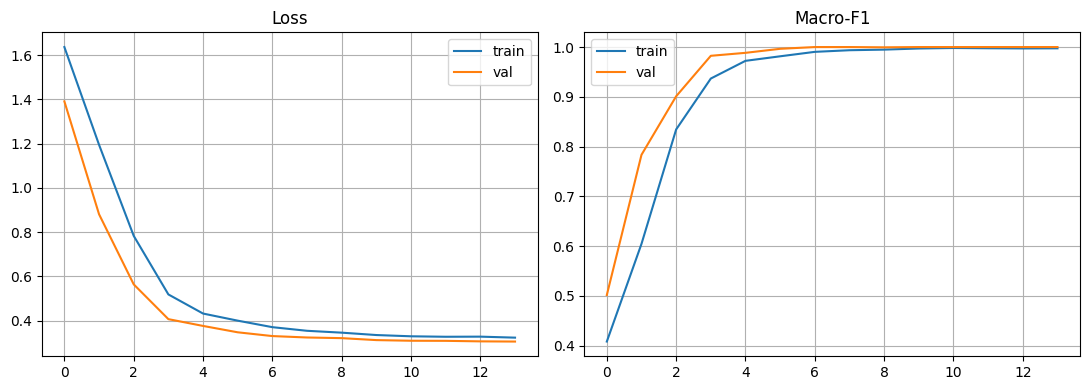

[PLOT] /content/drive/MyDrive/AI/Project_Summer_Module/DEMO/logs/curves.png
[BEST] val_macroF1=1.000 @ epoch 7 | ckpt: /content/drive/MyDrive/AI/Project_Summer_Module/DEMO/checkpoints/best.pt


In [ ]:
#Train loop with resume and early stopping
best_f1 = -1.0
best_epoch = -1
no_improve = 0
hist = defaultdict(list)
current_epoch = 0

#Resume if requested
last_ckpt = CKPT_DIR / "last.pt"
if RESUME_FROM_LAST and last_ckpt.exists():
    ckpt = torch.load(last_ckpt, map_location=DEVICE)
    model.load_state_dict(ckpt["model"])
    optim.load_state_dict(ckpt["optim"])
    scheduler.load_state_dict(ckpt["scheduler"])
    scaler.load_state_dict(ckpt["scaler"])
    current_epoch = ckpt.get("epoch", 0) + 1
    print(f"[RESUME] from epoch {current_epoch}")

for epoch in range(current_epoch, EPOCHS):
    model.train()
    t0 = time.time()
    running_loss = 0.0
    all_y, all_p = [], []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for xb, yb, _ in pbar:
        xb = xb.to(DEVICE)
        yb = torch.as_tensor(yb, device=DEVICE)

        optim.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=DEVICE if DEVICE=="cuda" else "cpu", dtype=torch.float16 if DEVICE=="cuda" else torch.bfloat16):
            logits = model(xb)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        all_y.append(yb.detach().cpu().numpy())
        all_p.append(preds.detach().cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_f1 = f1_score(np.concatenate(all_y), np.concatenate(all_p), average="macro")

    val_loss, val_f1 = evaluate(val_loader)

    #Step scheduler (epoch-based)
    scheduler.step()

    #Log
    hist["epoch"].append(epoch)
    hist["lr_head"].append(optim.param_groups[1]["lr"])
    hist["lr_backbone"].append(optim.param_groups[0]["lr"])
    hist["train_loss"].append(train_loss)
    hist["val_loss"].append(val_loss)
    hist["train_f1"].append(train_f1)
    hist["val_f1"].append(val_f1)

    #Save last model every epoch
    current_epoch = epoch
    save_checkpoint("last")

    #Early stopping on macro-F1
    improved = val_f1 > best_f1 + 1e-6
    if improved:
        best_f1, best_epoch = val_f1, epoch
        best_path = save_checkpoint("best")
    else:
        no_improve += 1

    dt = time.time() - t0
    print(f"[E{epoch+1:02d}] tr_loss={train_loss:.4f} val_loss={val_loss:.4f} "
          f"tr_f1={train_f1:.3f} val_f1={val_f1:.3f} | {dt:.1f}s")

    if not improved and no_improve >= EARLY_PATIENCE:
        print(f"[EARLY STOP] no improvement for {EARLY_PATIENCE} epochs.")
        break

#Save logs and plots
hist_df = pd.DataFrame(hist)
hist_csv = LOG_DIR / "training_log.csv"
hist_df.to_csv(hist_csv, index=False)
print(f"[LOG] saved: {hist_csv}")

import matplotlib.pyplot as plt

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train")
plt.plot(hist_df["epoch"], hist_df["val_loss"], label="val")
plt.title("Loss"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hist_df["epoch"], hist_df["train_f1"], label="train")
plt.plot(hist_df["epoch"], hist_df["val_f1"], label="val")
plt.title("Macro-F1"); plt.legend(); plt.grid(True)

plot_path = LOG_DIR / "curves.png"
plt.tight_layout(); plt.savefig(plot_path, dpi=160)
plt.show()
print(f"[PLOT] {plot_path}")

print(f"[BEST] val_macroF1={best_f1:.3f} @ epoch {best_epoch+1} | ckpt: {best_path}")


#7. (Optional) Quick reload cell after Colab reconnect (disconnect).

Run this to skip splitting and go straight to loaders + resume training.

In [ ]:
#QUICK RELOAD (run after reconnect)
#Rebuild datasets/loaders from saved CSVs, then you can re-run Section 5 and 6 blocks if needed.

import pandas as pd

train_csv = SPLIT_DIR / "train.csv"
val_csv   = SPLIT_DIR / "val.csv"
test_csv  = SPLIT_DIR / "test.csv"

df_train = pd.read_csv(train_csv)
df_val   = pd.read_csv(val_csv)
df_test  = pd.read_csv(test_csv)

train_ds = GhostDemoDataset(df_train, transform=train_tf)
val_ds   = GhostDemoDataset(df_val,   transform=eval_tf)
test_ds  = GhostDemoDataset(df_test,  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Reloaded — batches:", len(train_loader), len(val_loader), len(test_loader))
print("To resume, re-run the Model (Sec.5) then the Train loop (Sec.6).")


Reloaded — batches: 118 26 26
To resume, re-run the Model (Sec.4) then the Train loop (Sec.5).
